In [1]:
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import filters
from scipy import fftpack
from sklearn import metrics
import pydicom as dicom

In [2]:
class RadonTransform:
    def __init__(self, alpha, detectors, l_angle):
        self.alpha = alpha
        self.detectors = detectors
        self.l_angle = l_angle
        self.steps = round(180/self.alpha)

    def transform(self, image):
        sinogram = np.zeros((self.steps,self.detectors), dtype='float64')
        self.get_circle(image)
        x, y = image.shape
        x_circle, y_circle, r_circle = self.circle
        for s in range(self.steps):
            for d in range(self.detectors):
                x1 = r_circle * np.cos(np.deg2rad(s + (self.l_angle / 2) - d * (self.l_angle / (self.detectors - 1))))
                y1 = r_circle * np.sin(np.deg2rad(s + (self.l_angle / 2) - d * (self.l_angle / (self.detectors - 1))))
                x1 = int(x1) + (x // 2)
                y1 = int(y1) + (y // 2)

                x2 = r_circle * np.cos(np.deg2rad(s + 180 - (self.l_angle / 2) + d * (self.l_angle / (self.detectors - 1))))
                y2 = r_circle * np.sin(np.deg2rad(s + 180 - (self.l_angle / 2) + d * (self.l_angle / (self.detectors - 1))))
                x2 = int(x2) + (x // 2)
                y2 = int(y2) + (y // 2)

                xx,yy = RadonTransform.bresenham(x1,x2,y1,y2)
                sinogram[s,d] = sum(image[xx, yy])
        return sinogram

    def filtering(self, image):        
        filtered = np.zeros((self.steps, self.detectors))
        mask = self.get_mask()
        
        for step in range(self.steps):
            filtered[step] = signal.convolve(image[step], mask, mode = 'same', method='direct')
        return filtered

    def inverse_transform(self, sinogram):
        x_circle, y_circle, r_circle = self.circle
        size = round(2*r_circle)+2
        x, y = sinogram.shape
        image = np.zeros( (size, size), dtype='float64')
        pixels = np.zeros( (size, size), dtype='float64')
        for s in range(self.steps):
            for d in range(self.detectors):
                x1 = r_circle * np.cos(np.deg2rad(s + (self.l_angle / 2) - d * (self.l_angle / (self.detectors - 1))))
                y1 = r_circle * np.sin(np.deg2rad(s + (self.l_angle / 2) - d * (self.l_angle / (self.detectors - 1))))
                x1 = int(x1) + r_circle
                y1 = int(y1) + r_circle

                x2 = r_circle * np.cos(np.deg2rad(s + 180 - (self.l_angle / 2) + d * (self.l_angle / (self.detectors - 1))))
                y2 = r_circle * np.sin(np.deg2rad(s + 180 - (self.l_angle / 2) + d * (self.l_angle / (self.detectors - 1))))
                x2 = int(x2) + r_circle 
                y2 = int(y2) + r_circle
                xx, yy = RadonTransform.bresenham(x1,x2,y1,y2)
                image[xx,yy]+=sinogram[s,d]
                pixels[xx,yy]+=1
        return self.normalize_pixels(image, pixels, size)
    
    def normalize_pixels(self, image, pixels, size):
        for x in range(size):
            for y in range(size):
                if pixels[x,y] > 0:
                    image[x,y] = image[x,y]/ pixels[x,y]
        return image

    def get_circle(self, image):
        x, y = image.shape
        if x>=y:
            self.circle = (x//2, y//2, y//2-1)
        else:
            self.circle = (x//2, y//2, x//2-1) 

    def fft_transform(self, image):
        g_image = filters.gaussian(image, sigma=1)

        image_fft = fftpack.fft2(g_image)
        fraction = 0.2
        image_fft2 = image_fft.copy()
        x, y = image_fft2.shape
        image_fft2[int(x * fraction): int(x * (1 - fraction))] = 0
        image_fft2[:, int(y * fraction):int(y * (1 - fraction))] = 0
        image_f = fftpack.ifft2(image_fft2).real
        return image_f

    def get_mask(self):
        mask_size = int(np.floor(self.detectors / 2))
        mask = np.zeros(mask_size)
        mask_center = int(np.floor(mask_size/2))
        for i in range(mask_size):
            j = i - mask_center
            if j%2 != 0:
                mask[i] = (-4/np.pi**2) / (j**2)
        mask[mask_center] = 1
        return mask

    @staticmethod
    def bresenham(x1, x2, y1, y2):
        linex = []
        liney = []
        dx = x2 - x1
        dy = y2 - y1

        if dx >= 0:
            xi = 1
        else:
            xi = -1
            dx = -dx

        if dy >= 0:
            yi = 1
        else:
            yi = -1
            dy = -dy

        x = x1
        y = y1
        linex.append(int(x))
        liney.append(int(y))
        if dx >= dy:
            a = dx / 2
            for i in range(0, int(dx)):
                x += xi
                a -= dy
                if a < 0:
                    y += yi
                    a += dx
                linex.append(int(x))
                liney.append(int(y))
        else:
            a = dy / 2
            for i in range(0, int(dy)):
                y += yi
                a -= dx
                if a < 0:
                    x += xi
                    a += dy
                linex.append(int(x))
                liney.append(int(y))
        return np.asarray(linex), np.asarray(liney)
        

In [3]:
class Utils:
    @staticmethod
    def read_image(path):
        image = Image.open(path).convert('L')
        return np.asarray(image)

    @staticmethod
    def add_padding(image):
        x, y = image.shape
        pad_len = None
        if x == y:
            r = Utils.get_new_radius(image)
            new_len = 2 * r
            pad_len = int((new_len - x) / 2 + 10)
        image_with_padding = np.pad(image, pad_len, 'constant')
        return image_with_padding

    @staticmethod
    def get_new_radius(image):
        x = image.shape[0]
        y = image.shape[1]
        x = x / 2
        y = y / 2
        z = x ** 2 + y ** 2
        r = np.ceil(np.sqrt(z))
        return r

    @staticmethod
    def RMSE(image, inversed_image):
        image = image.copy()
        inversed_image = inversed_image.copy()
        x, y = image.shape
        for i in range(x):
            for j in range(y):
                image[i][j] /= 255
                inversed_image[i][j] /= 255
        return metrics.mean_squared_error(image, inversed_image, multioutput='uniform_average', squared=False)

    @staticmethod
    def read_dicom(file):
        dataset = dicom.dcmread(file)
        print(file)
        print(dataset.PatientName)
        print(dataset.StudyDate)
        print(dataset.ImageComments)

    @staticmethod
    def write_dicom(filename, file, name, date, comments):
        dataset = dicom.dcmread(file)
        dataset.PatientName = name
        dataset.StudyDate = date
        dataset.ImageComments = comments
        dataset.save_as(filename)
        print('DICOM file saved')


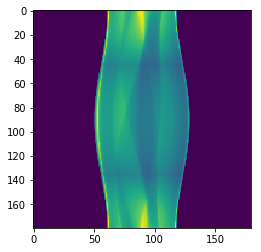

In [4]:
image = Utils.read_image("Shepp_logan.png")
image_with_padding = Utils.add_padding(image)
radon = RadonTransform(1,180,180)
radon_image = radon.transform(image_with_padding)
plt.figure()
plt.imshow(radon_image)
plt.show()

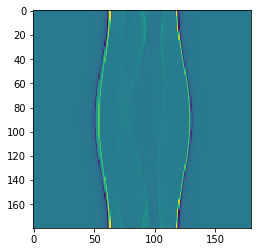

In [5]:
filtered_image = radon.filtering(radon_image)
plt.figure()
plt.imshow(filtered_image)
plt.show()

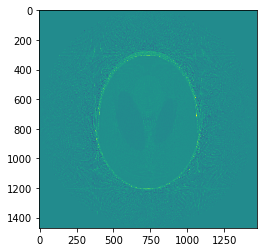

In [6]:
inversed_image = radon.inverse_transform(filtered_image)
plt.figure()
plt.imshow(inversed_image)
plt.show()

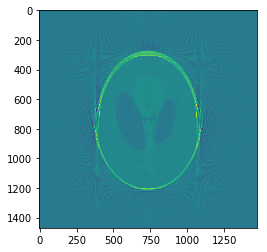

In [7]:
fft_image = radon.fft_transform(inversed_image)
plt.figure()
plt.imshow(fft_image)
plt.show()

In [8]:
print(Utils.RMSE(image_with_padding, fft_image))

2.5480323943101895


In [9]:
file = 'test.dcm'
patient_name = 'Jan Kowalski'
image_comments = 'Komentarz do zdjecia'
date = '20191008'
Utils.write_dicom(file, file, patient_name, date, image_comments)

DICOM file saved


In [10]:
Utils.read_dicom(file)

test.dcm
Jan Kowalski
20191008
Komentarz do zdjecia
